# Computational Neuroscience Crash Course (2021)
**Arthur Leblois & Nicolas P. Rougier**, Institute of Neurodegenerative Diseases, Bordeaux, France.  
Course material and program at https://github.com/bordeaux-neurocampus/CNCC-2021-beginner

<img style="float: right;" src="../figures/pixar.jpg">

## Sort the birds!

The goal of this project is to sort (automatically) audio files that correspond to the recording of adult or juvenile songbirds. If you listen to the audio files, you will hear that the sound is quite different between an adult (song) and a juvenile (babbling). This means we can probably process the audio files in order to decide if it corresponds to an adult or a juvenile and the goal is thus to write a function `songsort("./some-path/")` that will automatically sort all the files present in `some-path` and label them accordingly.

However, to do so, we'll need to manipulate a lot of different notions (such as resampling, filtering, enveloppe, auto-correlation, fit) and to check our implementation is correct. So let's start with a sample adult and juvenile audio file.

**Data** is available on [figshare](https://figshare.com/) and you can find it by searching for _songbird, leblois_. Once downloaded, you can unzip it in the project directory (where you have your notebook saved). Make sure the directory is named `records`.


**Content**

* [1. Configuration of the notebook](#1.-Configuration-of-the-notebook)
* [2. Loading libraries](#2.-Loading-libraries)
* [3. Loading data](#3.-Loading-data)
* [4. Visualizing data](#4.-Visualizing-data)
* [5. Denoising the signal](#5.-Denoising-the-signal)
* [6. Smoothing the signal](#6.-Smoothing-the-signal)
* [7. Resampling & Auto-correlation](#7.-Resampling-&-Auto-correlation)
* [8. Wrap-up](#8.-Wrap-up)
* [9. Batch processing](#9.-Batch-processing)
* [10. Fit the signal](#10.-Fit-the-signal)
* [11. Processing files](#11.-Processing-files)



### 1. Configuration of the notebook

We need first to setup a few options in the notebook such as to have inline plots as well as a nicer output on OSX.  
There is not much to understand here, these options are documented in the [Jupyer notebook documentation](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html)

In [1]:
# Ask jupyter to display plots inline
%matplotlib inline

# OSX specific (for a nicer display on "retina" screen)
%config InlineBackend.figure_format = 'retina'

**Note**: In order to run the code in a specific code cell, you'll have to type `shift`+`return` on the selected cell. If you do that manually, you'll have to run each cell from top to bottom (order is important). If you want to run all the cell, you can also click the run button at the top of the notebook. To edit a cell (code or text), double-click in it.

  
  
### 2. Loading libraries
Next step is to load all the Python libraries that will be needed for processing & displaying our data. Namely:
* [NumPy](https://www.numpy.org/) which is the fundamental package for scientific computing with Python.
* [Matplotlib](https://matplotlib.org/) which is a plotting library that produces publication quality figures. 
* [SciPy](https://www.scipy.org/) which is a Python-based ecosystem of open-source software for mathematics, science, and engineering.
* [IPython](https://ipython.org/) that provides a rich architecture for interactive computing

Note that during this course, we'll only use a small part of IPython (to play sound).

In [2]:
# Numerical package (we are importing numpy using the alias np)
import numpy as np

# TODO:
# Package to display figures (we need to import the submodule "pyplot" from "matplotlib" using the alias plt)
import matplotlib.pyplot as plt

# Signal processing (we need to import the submodule "signal" from "scipy", no alias)
import scipy.signal

# TODO:
# Package to read wav files (we need to import the submodule "wavfile" from the submodule "io" of "scipy")
from scipy.io import wavfile

# TODO: write this
# Package to display widgets inside the notebook (we need to import the submodules "Audio" and "display" from "IPython.display")
from IPython.display import Audio, display

### 3. Loading data

The first thing to do is to load our data from a local file that must be present in your `data` directory. To do that, we'll write a `get_data` function that reads a `wav` filename (`wav` file are sound files encoded in the [Waveform audio file format](https://fr.wikipedia.org/wiki/Waveform_Audio_File_Format)) using a dedicated function of scipy.

In [3]:
def get_data(filename = None):
    rate, signal = wavfile.read(filename)
    return rate, signal

We can now load some data and check for their properties.

In [4]:
filename = "./records/record-001.wav"

# TODO:
# write the code here that uses the function of the above cell to get the sampling rate of the audio file and the signal itself
rate, S = get_data(filename)

print("Frequency: {:.1f}kHz".format(rate/1000))
print("Length: {}".format(len(S)))

Frequency: 44.1kHz
Length: 530833


#### Exercise
The file has been read and we know that the frequency is 44.1 kHz and the number of data points is 530833.  
Try to compute the duration of the signal.

In [5]:
# TODO:
# Compute the duration of the signal
duration = len(S)/rate

print("Frequency: {:.1f}kHz".format(rate/1000))
print("Duration: {:.2f} seconds".format(duration))

Frequency: 44.1kHz
Duration: 12.04 seconds



### 4. Visualizing data

We can now display our data using the `plot` function from matplotlib. To do that, we need to have the X and Y coordinates of points. The Y data is given by the `signal` but we need to generate the corresponding X data. Knowing the duration and the number of Y data, we can write X using the numpy [linspace(start,stop,num)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) function:

In [6]:
# TODO:
# Use linspace from numpy (np.linspace) to generate the time vector T
T = np.linspace(0, duration, len(S))

We're now ready to create a new figure and plot our data

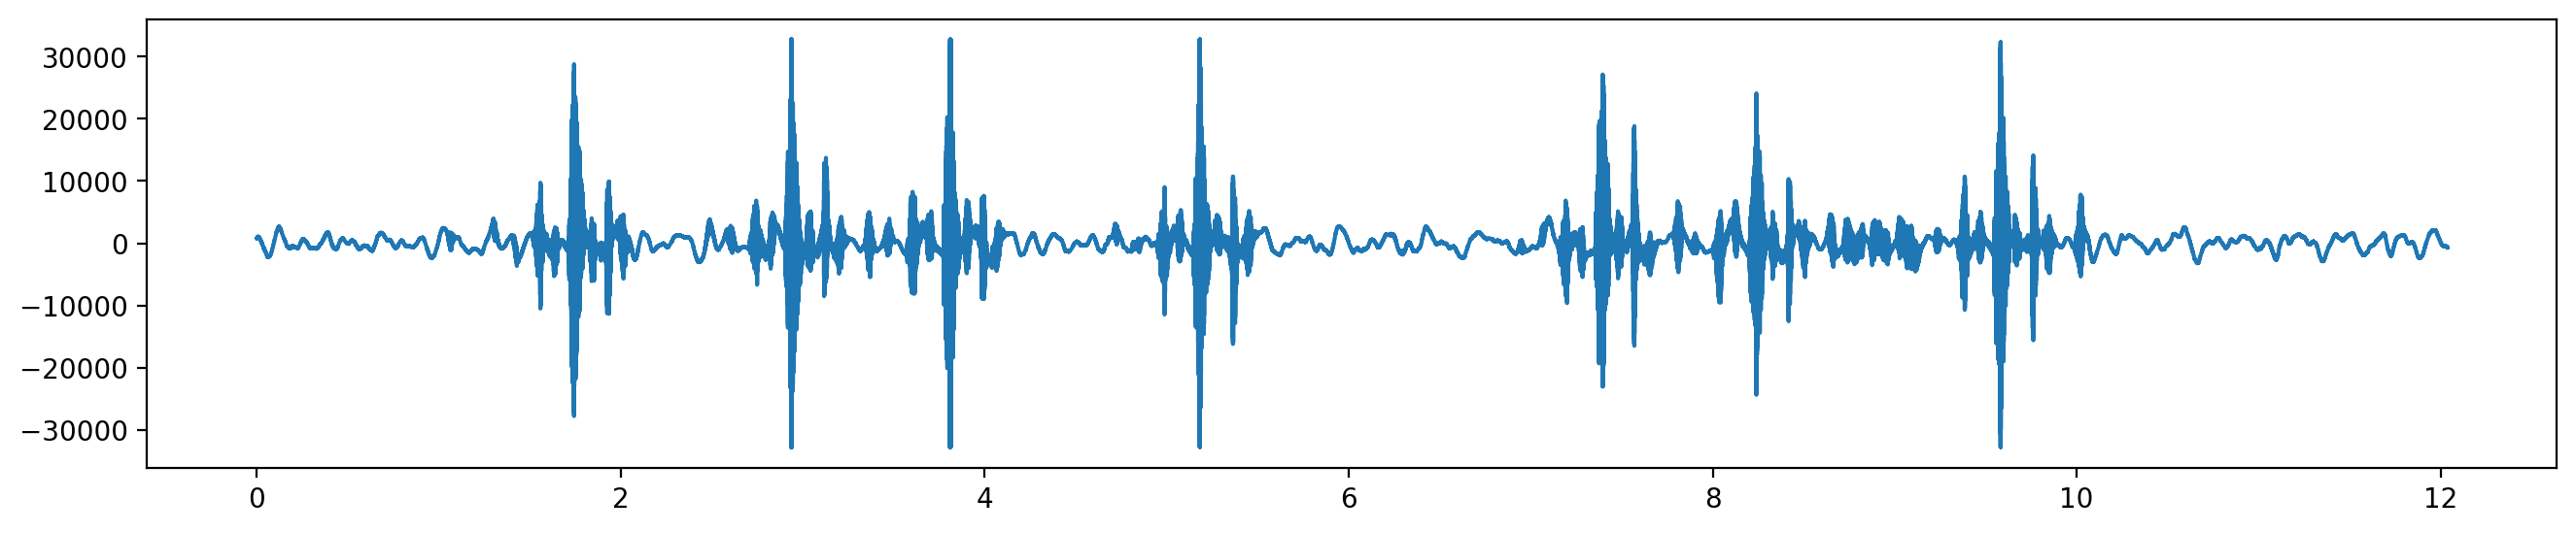

In [7]:
plt.figure(figsize=(16,3))
plt.plot(T, S);

If you want to see only a subpart of the signal, you can limit explicitely the x range using the [xlim(xmin,xmax)](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.xlim.html) function as shown below where we modified the y range as well using the [ylim(ymin,ymax)](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.ylim.html)

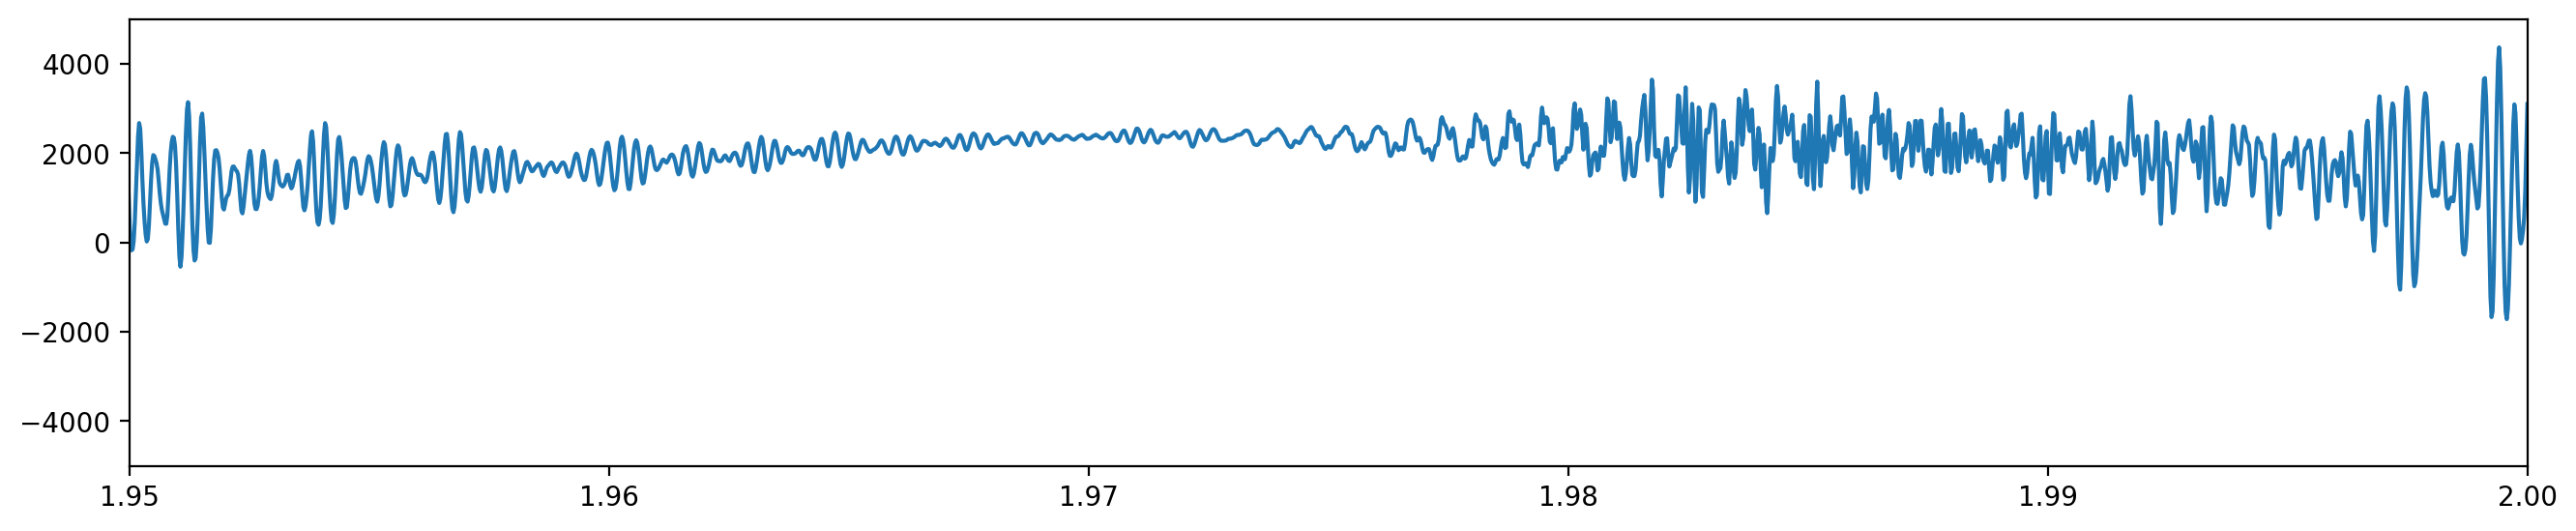

In [8]:
plt.figure(figsize=(16,3))
plt.plot(T, S);
plt.xlim(1.95,2.0);
plt.ylim(-5000,5000);

Furthermore, and knowing our data is an audio file, we can benefit from a better visualization using the [specgram](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html) function of matplotlib that is dedicated to the visualization of spectrogram.

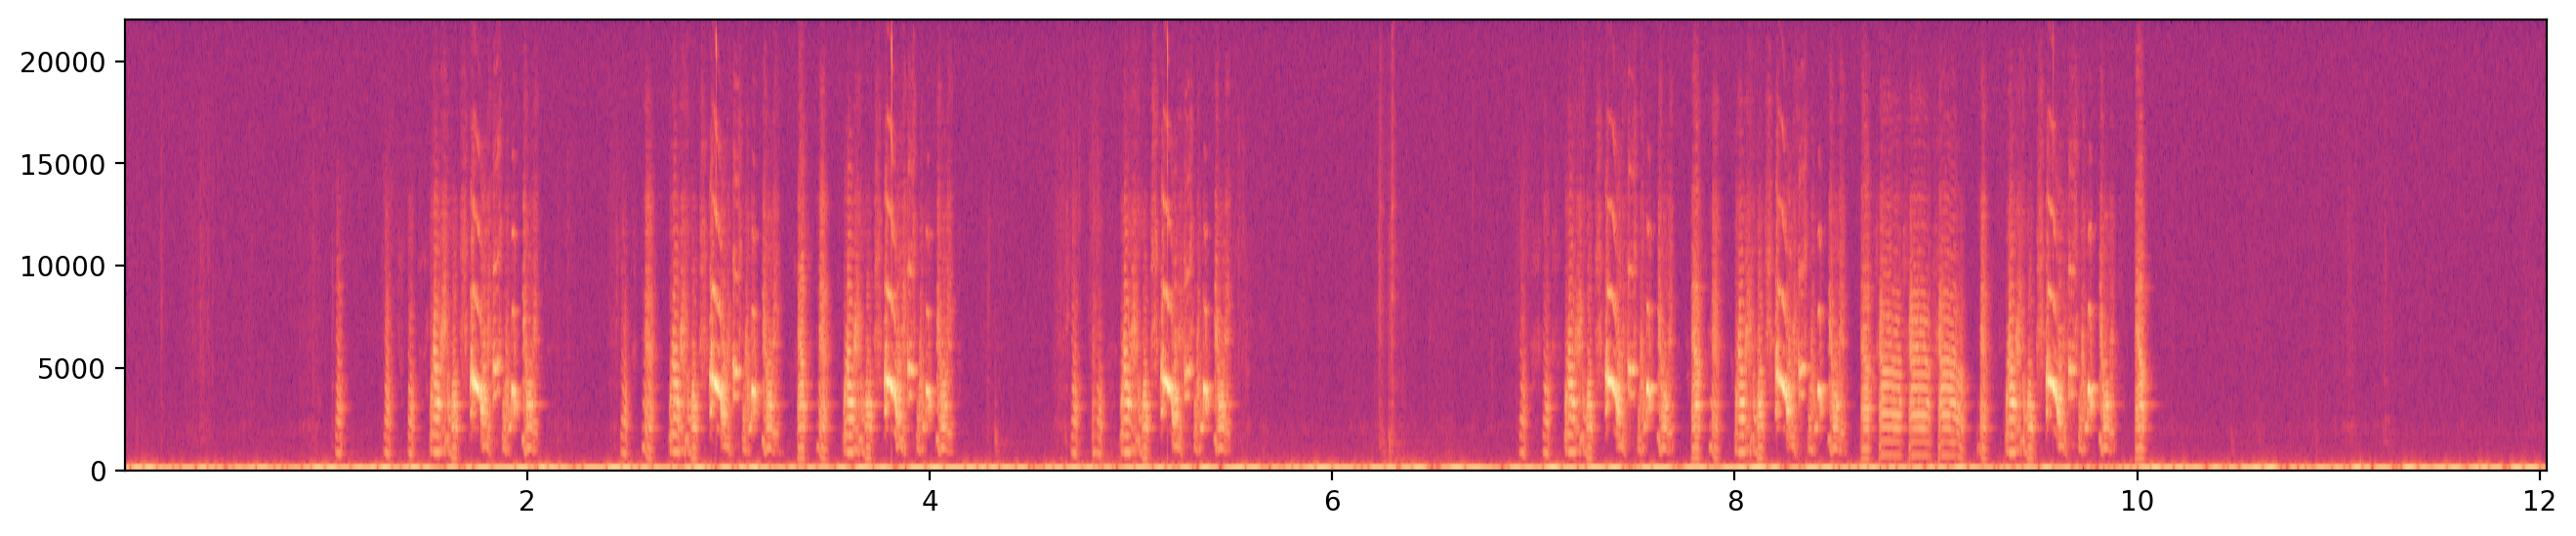

In [9]:
plt.figure(figsize=(16,3))
plt.specgram(S, Fs=rate, cmap="magma");

And last, but not least, using the IPython library, we can display a widget in order to play the file.

In [10]:
# Display a widget to play the sound
display(Audio(filename))

### 5. Denoising the signal

Before going any further in our processing, we need to remove noise originating from recording default and ambient noise. We'll use a [high-pass filter (HPF)](https://en.wikipedia.org/wiki/High-pass_filter) that is  *an electronic filter that passes signals with a frequency higher than a certain cutoff frequency and attenuates signals with frequencies lower than the cutoff frequency* (Wikipedia). To do that, we first need to build a filter among [those available](https://docs.scipy.org/doc/scipy/reference/signal.html) and we apply the filter to our signal.

In [ ]:
# TODO:
# Create a highpass filter in the format [b,a] at a cut-off frequency of 500Hz
# Hint: read the documentation on scipy.signal and the provided filtering notebook
#...

# Apply the filter to the original signal
#...

# Calculate the difference between the original and the filtered signals
#...

# and plot the filtered signal and the calculated difference
plt.figure(figsize=(16,3))
plt.plot(T, S_);
plt.plot(T, D);

# Keep in mind we will be using the *filtered* signal from now on!
#...

In [ ]:
# Use the specgram function again to plot the filtered signal
plt.figure(figsize=(16,3))

#...

Let's listen to a comparison between the original (noisy) and the filtered (denoised) signal:

In [ ]:
# Noisy version
display(Audio(S, rate=rate));

In [ ]:
# Denoised signal
#...



### 6. Smoothing the signal

We want to smooth the signal by averaging each value with neighboring values, using a Gaussian window. To do that, we first need to define the neighboring range (in seconds). Then we define a gaussian signal over this range and centered in the middle and finally we compute the smooth signal (enveloppe).

In [ ]:
# Duration of the time window over which to smooth the signal
dt = 0.025
trange = int(dt*rate)

# Standard deviation of the gaussian
sigma = trange/4

# Actual temporal window over which to compute the Gaussian
window = np.arange(-trange//2,trange//2)

# Gaussian function over window and standard deviation sigma
gaussian = np.exp(-(window/sigma)**2)

Let us visualize our smoothing window.

In [ ]:
# Plot the Gaussian 
plt.plot(window/rate, gaussian);

Now, let us compte the envelope using the  convolution product that is mathematically defined as:
$(f * g)(t) \triangleq\ \int_{-\infty}^\infty f(t-\tau) g(\tau)\, d\tau$

The illustration below (from the [Wikipedia page on convolution](https://en.wikipedia.org/wiki/Convolution)) shows how it is computed:

![](https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif)


In [ ]:
# Smooth the signal using the numpy convolution function
#...


If we did things properly, the signal and it enveloppe variations should be aligned.  
Let's check:

In [ ]:
# Display the raw signal and the spectrogram
T = np.linspace(0, duration, len(S))
plt.figure(figsize=(16,3))
plt.plot(T, abs(S), alpha=0.5) # original signal
#... # convolution

plt.xlim(1,3);#plt.ylim(0,30000);


### 7. Resampling & Auto-correlation

We can now compute the auto-correlation of the signal, that is, the correlation of the signal by itself. Howewer, since the signal is quite large, we'll first extract only a few points linearly spread over the signal and then compute the auto-correlation.

In [ ]:
E1 = E[::1]
E10 = E[::10]
E100 = E[::100]
E1000 = E[::1000]
E10000 = E[::10000]
print(len(E1),len(E10), len(E100), len(E1000), len(E10000))

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(np.linspace(0,duration,len(E100)), E100)
plt.plot(np.linspace(0,duration,len(E10000)), E10000)

In [ ]:
E = E[::100]
C = np.correlate(E, E, mode='same') / (E**2).sum()

An we can now visualize the result in the frequency domain.

In [ ]:
T = .5*np.linspace(-len(S)/rate, +len(S)/rate , len(C))
plt.plot(T, C);
plt.xlim(-0.5,0.5)

We can visually see there is a peak a the center. Let's see what happens for a juvenile.

### 8. Wrap-up

It's now time to write a function that, given a wav file, compute the auto-corraltion. To do this, we just need to wrap-up what we've written so far and choose the relevant arguments to give when we call the function.

In [ ]:
def autocorr(data, dt=0.025):
    """
    Compute the auto-correlation of an audio signal using a Gaussian
    smoothing window (with duration dt)
    
    data: (rate, signal)
        data is an audio signal made of 2 variables. First one (rate)
        is the frequency of the signal and second one (signal) is the
        actual signal.
    
    dt: float
        Duration of the time window (Gaussian) to smooth the signal. 
        Default value is 250 milliseconds.
    """
    
    #...
    return T, C

### 9. Batch processing

So far, we've working with a unique file whose name was known to us. We would like now to process all the wav files in the data directory. This means we need to first find them and then process them. To do that, we'll use the [glob](https://docs.python.org/3/library/glob.html) library:

In [ ]:
import glob
files = glob.glob("./records/*.wav")[:4] # can you understand what does this line do?

# Let's plot some data
ax = None
plt.figure(figsize=(16,4))
for index, filename in enumerate(files):
    T, C = autocorr(get_data(filename))
    ax = plt.subplot(1, 4, 1+index, aspect=1, sharey=ax);
    ax.plot(T, C);
    ax.set_xlim(-0.5,0.5);
    ax.set_title(filename)

### 10. Fit the signal

It seems the auto-correlation of adults is much more complicated than the one of juveniles. More precisely, the juveniles look like a kind of Gaussian while the adults look like a periodic Gaussian. Consequently, if we try to fit juveniles with a Gaussian, the difference between the fit and the actual signal might be relatively small while for adults it shoudl be much bigger. Let's just try that.



We'll use the [curve_fit](https://scipy.github.io/devdocs/generated/scipy.optimize.curve_fit.html) function from [scipy.optimize](https://scipy.github.io/devdocs/optimize.html) that, given a parameterized function, will search for the best combination of parameter. So let's write a Gaussian function:

In [ ]:
from scipy.optimize import curve_fit

# Gaussian we want to use for fitting
def exponential(X, a, b, c):
    return a*np.exp(-((X/b)**2)) + c

# We get the auto-correlation
#...

# We extract the value between tmin and tmax
#...

# We fit the curve
#...

# We display the result
plt.figure(figsize=(6,4), dpi=100);
plt.plot(T, C, color='#999999');
plt.plot(T, G, color='k', lw=2);
plt.title("Original signal and fitted Gaussian");

# We compute the score
#...

# We print the score
print("Score: {0}".format(score))

Let's wrap everything into a score function.

In [ ]:
def score(filename, tmin=-0.5, tmax=0.5):
    #...
    return 0 # change this too
    
files = glob.glob("./records/*.wav")[:10]
for filename in files:
    print("{0} : {1}".format(filename, score(filename)))

### 11. Processing files

We can now use our function to score each and every `wav` file in the data directory.
**Be careful, it'll take some time to compute**.  
Consequently, we'll use the [tqdm package](https://pypi.org/project/tqdm/) to show progress wchil computing individual score.

In [ ]:
from tqdm import notebook
files = glob.glob("./records/*.wav")

scores = []
for filename in notebook.tqdm(files):
    scores.append(score(filename))

If our hypothesis regarding the fitting of the Gaussian for adults and juveniles is right, we should have two groups of score, one low and one high. Let's plot an histogram to check visually if it is true.

In [ ]:
plt.hist(scores, bins=50);
plt.title("Histogram of Gaussian-fit score");

We can clearly see on the graph above that there are two different groups of score. Visually, the frontiers between the two groups seems to be a score of 20.

In [ ]:
scores = np.array(scores)
print( (scores < 20).sum(), (20 <= scores).sum())